##### What observations are there? how are they distributed in space and time? (GLODAPv2.2021)

extract only SO points with valid DIC and TA 

##### How does DIC, TA, T, S from T001, M001 runs compare?

next steps - add model output to dataframes. calculate bias in DIC, TA, s, t, 

In [222]:
clear

In [223]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [224]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

#import mapfxn as mf
#reload(mf)

plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [225]:
#load data, extract only the data you need
runhorse = False
if runhorse:

    tdir = '/gpfs/home/mep22dku/scratch/'
    glodap = pd.read_csv(f'{tdir}GLODAPv2.2021_Merged_Master_File.csv')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    print(glodap.head())

    tDIC = np.array(glodap['G2tco2'][:])
    tco2f = np.array(glodap['G2tco2f'][:])
    tco2qc = np.array(glodap['G2tco2qc'][:])

    tALK = np.array(glodap['G2talk'][:])
    talkf = np.array(glodap['G2talkf'][:])
    tco2f = np.array(glodap['G2tco2f'][:])

    tSAL = np.array(glodap['G2salinity'][:])
    tTEMP = np.array(glodap['G2temperature'][:])
    tPRES = np.array(glodap['G2pressure'][:])
    tLAT = np.array(glodap['G2latitude'][:])
    tLON = np.array(glodap['G2longitude'][:])
    tYEAR = np.array(glodap['G2year'])
    tMONTH = np.array(glodap['G2month'])
    #tAOU = np.array(glodap['aou'][:])

    dens = seawater.dens(tSAL,tTEMP,tPRES)
    tDIC=tDIC*dens/1000
    tALK=tALK*dens/1000

    tALK_DIC = tALK-tDIC
    tALK_DIC2 = tALK-(tDIC+50)

    tfilt = (tLAT <= -50) & (tco2f < 9) & (talkf <9)
    tDIC_SO = tDIC[tfilt]
    tco2f_SO =  tco2f[tfilt]
    tco2qc_SO = tco2qc[tfilt]
    tALK_SO = tALK[tfilt]
    talkf_SO = talkf[tfilt]
    tco2f_SO = tco2f[tfilt]

    tSAL_SO = tSAL[tfilt]
    tTEMP_SO = tTEMP[tfilt]
    tPRES_SO = tPRES[tfilt]
    tLAT_SO = tLAT[tfilt]
    tLON_SO = tLON[tfilt]
    tYEAR_SO = tYEAR[tfilt]
    tMONTH_SO = tMONTH[tfilt]
    tSECT_SO = np.zeros_like(tLON_SO)
    tSECT_SO[(tLON_SO <= -67) | (tLON_SO > 150)] = 4 #pacific
    tSECT_SO[(tLON_SO <= 20) &(tLON_SO > -67)] = 2 #atl
    tSECT_SO[(tLON_SO > 20) &(tLON_SO <= 150)] = 3 #indian

    print(np.shape(tYEAR_SO))
    df = pd.DataFrame([tYEAR_SO,tMONTH_SO,tDIC_SO,tALK_SO,tSAL_SO,tTEMP_SO,tPRES_SO,tLAT_SO,tLON_SO,tSECT_SO]).T
    df.columns = ['YR', 'MONTH', 'DIC', 'ALK', 'SAL', 'TEMP', 'PRES', 'LAT', 'LON', 'SECT']
    df.to_csv('./GLODAPv2.2021_SO_valid_DICTA_umolL.csv')


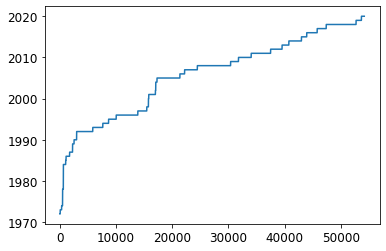

In [226]:
df = pd.read_csv('GLODAPv2.2021_SO_valid_DICTA_umolL.csv')
df = df.sort_values(by = 'YR')

tDIC_SO = np.array(df['DIC'][:])
tALK_SO = np.array(df['ALK'][:])


tSAL_SO = np.array(df['SAL'][:])
tTEMP_SO = np.array(df['TEMP'][:])
tPRES_SO = np.array(df['PRES'][:])
tLAT_SO = np.array(df['LAT'][:])
tLON_SO = np.array(df['LON'][:])
tYEAR_SO = np.array(df['YR'])
tMONTH_SO = np.array(df['MONTH'])
tSECT_SO = np.array(df['SECT'])

plt.plot(tYEAR_SO)

In [227]:
yrs = np.arange(1972,2021,1)
OBS_depths = np.zeros([5,len(yrs)])
OBS_seas = np.zeros([4,len(yrs)])
OBS_lats = np.zeros([6,len(yrs)])
OBS_sects = np.zeros([3,len(yrs)])

for i in range(0,len(yrs)):
    tyr = yrs[i]

    
    OBS_depths[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO<=200)])
    OBS_depths[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>200) & (tPRES_SO<=500)]) 
    OBS_depths[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>500) & (tPRES_SO<=1000)]) 
    OBS_depths[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>1000) & (tPRES_SO<=3000)]) 
    OBS_depths[4,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tPRES_SO>3000)]) 
    
    #spring
    OBS_seas[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO<=11) & (tMONTH_SO>8)]) #spring
    OBS_seas[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tMONTH_SO==12) | (tMONTH_SO<=2))])  #sumer
    OBS_seas[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>2) & (tMONTH_SO<=5)]) #autum
    OBS_seas[3,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tMONTH_SO>5) & (tMONTH_SO<=8)]) #winter
    
    #sectors
#spring
    OBS_sects[0,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 2)]) #atl
    OBS_sects[1,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & (tSECT_SO == 3)])  #ind
    OBS_sects[2,i] = np.size(tDIC_SO[(tYEAR_SO == tyr) & ((tSECT_SO == 4))]) #pac  

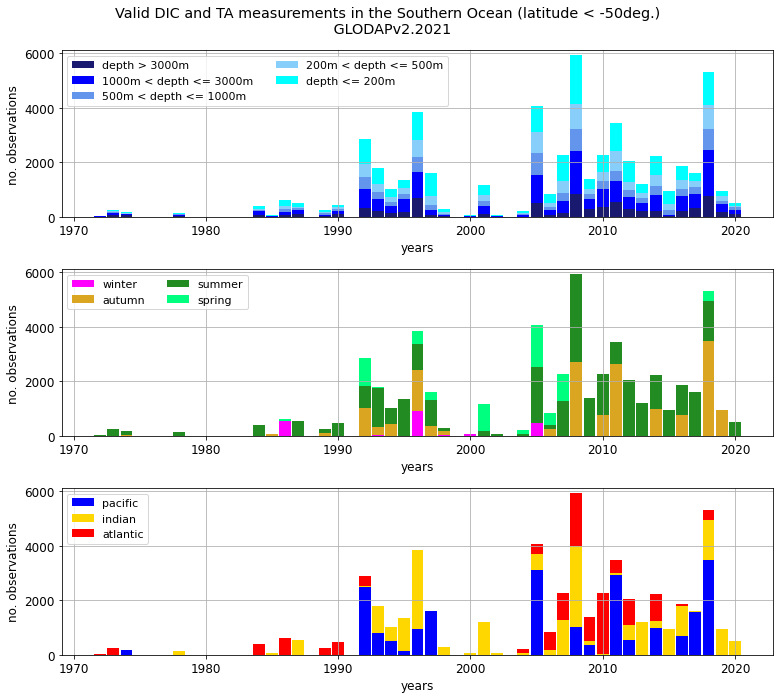

In [235]:
fact = 0.55
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
fs = 11
width = 0.9
axs[0].bar(yrs,OBS_depths[4,:],width, color = 'midnightblue', label = 'depth > 3000m')
axs[0].bar(yrs,OBS_depths[3,:],width, bottom = OBS_depths[4,:], color = 'b', label = '1000m < depth <= 3000m')
axs[0].bar(yrs,OBS_depths[2,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:], color = 'cornflowerblue', label = '500m < depth <= 1000m')
axs[0].bar(yrs,OBS_depths[1,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:], color = 'lightskyblue', label = '200m < depth <= 500m')
axs[0].bar(yrs,OBS_depths[0,:],width, bottom = OBS_depths[4,:]+ OBS_depths[3,:]+OBS_depths[2,:]+OBS_depths[1,:], color = 'cyan', label = 'depth <= 200m')
axs[0].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[1].bar(yrs,OBS_seas[3,:],width,  color = 'magenta', label = 'winter')
axs[1].bar(yrs,OBS_seas[2,:],width, bottom = OBS_seas[3,:], color = 'goldenrod', label = 'autumn')
axs[1].bar(yrs,OBS_seas[1,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:], color = 'forestgreen', label = 'summer')
axs[1].bar(yrs,OBS_seas[0,:],width, bottom = OBS_seas[3,:]+OBS_seas[2,:]+OBS_seas[1,:], color = 'springgreen', label = 'spring')
axs[1].legend(ncol = 2, loc = 'best', fontsize = fs)

axs[2].bar(yrs,OBS_sects[2,:],width,  color = 'b', label = 'pacific')
axs[2].bar(yrs,OBS_sects[1,:],width, bottom = OBS_sects[2,:], color = 'gold', label = 'indian')
axs[2].bar(yrs,OBS_sects[0,:],width, bottom = OBS_sects[2,:]+OBS_sects[1,:], color = 'r', label = 'atlantic')
axs[2].legend(ncol = 1, loc = 'best', fontsize = fs)
# ax.bar(x, diat_means, width, yerr=men_std, label='diat',color = 'r', alpha = 0.8)
# ax.bar(x, flag_means, width, yerr=women_std, bottom=diat_means,
#        label='flag', color = 'r', hatch='.', alpha = 0.6)

for i in range(0,3):
    axs[i].set_ylim([0,6100])
    axs[i].grid()
    axs[i].set_xlabel('years'); axs[i].set_ylabel('no. observations')

plt.suptitle('Valid DIC and TA measurements in the Southern Ocean (latitude < -50deg.) \n GLODAPv2.2021')
plt.tight_layout()

In [229]:
now = datetime.now()
print(now)

td = nc.Dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/WOA_DIC_1990_all.nc')
lons = (td['lon'][:]-180)
lats = (td['lat'][:])
depths = (td['deptht'][:])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arval = array[idx]
    return(idx, arval)

tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_M001/'
mod_dics_M001 = np.zeros_like(tDIC_SO)
for i in range(0,len(tYEAR_SO)):
    tyr = tYEAR_SO[i]
    tdic = tDIC_SO[i]
    tdepth = tPRES_SO[i]
    tlat = tLAT_SO[i]
    tlon = tLON_SO[i]
    tmonth = tMONTH_SO[i]

    if i == 0:
        print(i)
        print(tyr)
        tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    elif (tyrold != tyr):
        print(tyr)
        tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
    idx_d, arval = find_nearest(depths,tdepth)
    idx_lat, arval = find_nearest(lats,tlat)
    idx_lon, arval = find_nearest(lons,tlon)
    
    mod_dics_M001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
    tyrold = tyr

tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_T001/'
mod_dics_T001 = np.zeros_like(tDIC_SO)
for i in range(0,len(tYEAR_SO)):
    tyr = tYEAR_SO[i]
    tdic = tDIC_SO[i]
    tdepth = tPRES_SO[i]
    tlat = tLAT_SO[i]
    tlon = tLON_SO[i]
    tmonth = tMONTH_SO[i]

    if i == 0:
        print(i)
        print(tyr)
        tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    elif (tyrold != tyr):
        print(tyr)
        tnc = nc.Dataset(f'{tdir}WOA_DIC_{int(tyr)}_all.nc')
    
    idx_d, arval = find_nearest(depths,tdepth)
    idx_lat, arval = find_nearest(lats,tlat)
    idx_lon, arval = find_nearest(lons,tlon)
    
    mod_dics_T001[i] = (tnc['DIC'][tmonth-1,idx_d,idx_lat,idx_lon])*1e6
    tyrold = tyr
    
now2 = datetime.now()
print(now2-now)


2022-04-04 14:19:43.815494
0
1972.0
1973.0
1974.0
1978.0
1984.0
1985.0
1986.0
1987.0
1989.0
1990.0
1992.0
1993.0
1994.0
1995.0
1996.0
1997.0
1998.0
2000.0
2001.0
2002.0
2004.0
2005.0
2006.0
2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
2019.0
2020.0
0
1972.0
1973.0
1974.0
1978.0
1984.0
1985.0
1986.0
1987.0
1989.0
1990.0
1992.0
1993.0
1994.0
1995.0
1996.0
1997.0
1998.0
2000.0
2001.0
2002.0
2004.0
2005.0
2006.0
2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
2019.0
2020.0
0:02:01.841398


In [230]:
print(np.shape(mod_dics_T001))

(54187,)


(1500.0, 2600.0)

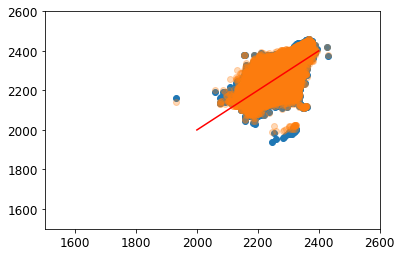

In [231]:
plt.scatter(tDIC_SO,mod_dics_M001)
plt.scatter(tDIC_SO,mod_dics_T001, alpha = 0.3)
# plt.scatter(tDIC_SO,mod_dics_T001,'ko')
plt.plot([2000,2400],[2000,2400],'r-')
plt.xlim([1500,2600])
plt.ylim([1500,2600])

In [232]:
# tDIC_SO = tDIC[tfilt]
# tco2f_SO =  tco2f[tfilt]
# tco2qc_SO = tco2qc[tfilt]
# tALK_SO = tALK[tfilt]
# talkf_SO = talkf[tfilt]
# tco2f_SO = tco2f[tfilt]

# tSAL_SO = tSAL[tfilt]
# tTEMP_SO = tTEMP[tfilt]
# tPRES_SO = tPRES[tfilt]
# tLAT_SO = tLAT[tfilt]
# tLON_SO = tLON[tfilt]
# tYEAR_SO = tYEAR[tfilt]
# tMONTH_SO = tMONTH[tfilt]
# tSECT_SO
# df = pd.DataFrame(np.hstack((arr1, arr2, arr3)), 
#                   columns=['arr{}'.format(i+1) for i in range(3)])


# df = pd.DataFrame(np.hstack(tYEAR_SO.transpose(), tDIC_SO.transpose(), tALK_SO.transpose()), columns = ['YEAR','DIC', 'ALK'])